In [15]:
import numpy as np
import math
import scipy.stats as sc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx
import time
import ipywidgets as wg

import graphviz
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

import IPython
from IPython.display import HTML, display, clear_output

import pickle

from astropy import stats

# Ising model function definitions

In [16]:
def energy_calc(lat):
    ''' Calculated total energy of the lattice.
    
        Parameters:
            lat: [N] numpy array containing only 1 and -1 values representing the spin configuration.
        
        Returns: dtype float
            Energy of the spin configuration'''
    
    a = lat[:N-1]*lat[1:]
    # To ensure periodic boundary conditions (or to have the chain) the last entry is multiplied with the first entry of the lattice array. 
    b = lat[0]*lat[N-1]
    # Energy:
    E = -1*(np.sum(a)+np.sum(b))
    return(E)

In [17]:
def energy_nn(lat,x):
    ''' Calculate nearest neighbour interaction energy of 1 spin in the lattice.
    
        Parameters:
            lat: dtype numpy array
                [N] numpy array containing only 1 and -1 values representing the spin configuration.
            
            x: dtype int
                The coordinate of the spin of interest
        
        Returns: dtype float
             nearest neighbour interaction energy of the selected spin '''
    
    s = lat[x]
    nn = lat[(x+1)%N] + lat[(x-1)%N] 
    E = -1*nn*s
    return(E)

In [18]:
def specific_heat(x):
    ''' Calculates specific heat.
        
        Parameters: 
            x: dtype numpy array
                One dimensional array containing the energy data (or equivalent quantity)
            
        Returns: dtype numpy array
            One dimensional array containing the specific heat data'''
    
    cv = (np.var(x))/(T**2)
    return(cv)

In [19]:
def susceptiblity(mag):
    ''' Calculates specific heat.
        
        Parameters: 
            mag: dtype numpy array
                One dimensional array containing the magnetization data
            
        Returns: dtype numpy array
            One dimensional array containing the susceptibility data'''
    
    susc = (np.var(mag))/T
    return(susc)

In [20]:
def metropolis(lat,E,M):
    ''' Implement metropolis algorithm for a single spin flip.
    
        Parameters: 
            lat: dtype numpy array
                [N] array representing the lattice
            E: dtype float or int
                Energy of the lattice
            M: dtype float or int
                Magnetization of the lattice
        Returns: dtype tuple
            Tuple containing the updated lattice and the corresponding energy and magnetization'''
    
    # Select random spin (propose trial lattice with probability 1/L):
    x = np.random.randint(0,N)
    trial_lat = np.copy(lat)
    trial_lat[x] *= -1
    # Calculate energy difference between the old and trial configurations:
    dE = energy_nn(trial_lat,x) - energy_nn(lat,x)
    # Implement second stage of the metropolis algorithm:
    if dE <= 0:
        E = E + dE
        M = M - lat[x] + trial_lat[x] # substract old spin value and add new spin value to the magnetisation
        lat[x] = trial_lat[x]
    else:
        r = np.random.uniform(0,1)
        #p=np.exp(-dE/tau)
        p = exp[0]
        if r < p:
            E = E + dE
            M = M - lat[x] + trial_lat[x] # substract old spin value and add new spin value to the magnetisation
            lat[x] = trial_lat[x]
    return(lat,E,M)

In [21]:
def Wolffbacktrack(x,cluster,visited):
    ''' Part of the Wolff algorithm, it checks whether a spin is already in the cluster'''
    if cluster[x]:
        return False
    if visited[x]:
        return True#False
    return True

def grow_cluster(lattice,x,ClusterSpin,E,M, cluster,visited):
    """ Starting from a randomly chosen spin, creates a cluster with the Wolff Algorithm.
        
        Parameters:
            lattice: dtype numpy array
                The [N] array representing the spin configuration
            
            x: dtype int
                The coordinate of the spin that is added to the cluster
                
            ClusterSpin: dtype int
                The spin value of the cluster
            
            E and M: dtype int or float
                The energy and magnetization of the lattice
            
            cluster: dtype boolean numpy array
                [N] boolean numpy array indicating which spins are in the cluster
                
            visited: dtype boolean numpy array
                [N] boolean numpy array indicating which spins have already been trialed by the algorithm
                
        Returns: dtype tuple
            Tuple containing the updated lattice and the corresponding energy and magnetization"""
    
    old_E = energy_nn(lattice,x)
    lattice[x] *=-1
    dE = energy_nn(lattice,x) - old_E
    E = E + dE
    M = M - lattice[x]*-1 +lattice[x]
    #cluster.append([x,y])
    cluster[x] = True
    if Wolffbacktrack((x+1)%N, cluster, visited):
        E, M = try_add(lattice,(x+1)%N, ClusterSpin,E, M, cluster, visited)
    if Wolffbacktrack((x-1)%N, cluster, visited):
        E, M = try_add(lattice,(x-1)%N, ClusterSpin,E, M, cluster, visited)
    return(lattice,E,M)

def try_add(lattice,x,ClusterSpin,E,M, cluster, visited):
    """Checks of neighbor belongs to cluster, if so then add neighbor to cluster with a certain probability"""
    
    s_help = lattice[x]
    #global tau
    if ((s_help<0) != (ClusterSpin<0)):
        r = np.random.uniform(0,1)
        if r < (1-A_wolff):
            lattice, E, M = grow_cluster(lattice, x, ClusterSpin, E, M, cluster, visited)
        else:
            visited[x] = True
    return(E,M)

def Wolff(lattice, E, M):
    ''' Implements the wolff algorithm for a single timestep.
        
        Parameters: 
            lattice: dtype numpy array
                [N] array representing the lattice
            E: dtype float or int
                Energy of the lattice
            M: dtype float or int
                Magnetization of the lattice
        Returns: dtype tuple
            Tuple containing the updated lattice and the corresponding energy and magnetization'''
    
    x = np.random.randint(0,N)
    cluster = np.full((N), False, dtype=bool)
    visited = np.full((N), False, dtype=bool)
    clusterspin = lattice[x]*-1
    lattice, E, M = grow_cluster(lattice,x,clusterspin, E, M, cluster, visited)
    return(lattice,E,M)

# Correspondence function definitions

In [22]:
def create_frozen_map(lat):
    """ Creates a boolean map of (freezes) all bonds (nn interactions) in the lattice
    
        Input:
            lat: dtype numpy array
                [N] array containing only 1 and -1 values representing the spin configuration
            
        Returns:
            f_map: dtype numpy array
                [N] boolean array containing True if bond is present or False if not. For example spin lattice [1, -1, 1, 1]
                corresponds to f_map [True, True, False, False]
    """
    lat = np.array(lat)
    a = lat[1:]-lat[0:len(lat)-1]; b = lat[0]-lat[len(lat)-1]
    c = np.append(a,b)
    f_map = (c == 0)
    return(f_map)

In [23]:
def backtrack(x,vis,fm,cl):
    """ Part of the cluster decomposition. It recursively checks whether neighbouring spin should be added to the cluster
    """
    if not vis[x]:
        vis[x] = True
        cl.append(x)
        if fm[x]:
            vis, cl = backtrack((x+1)%len(fm),vis,fm,cl)
        if fm[(x-1)%len(fm)]:
            vis, cl = backtrack((x-1)%len(fm),vis,fm,cl)
    return(vis,cl)

In [24]:
def cluster_decomp(lat):
    """ Decomposes the spin lattice into clusters, i.e. creates list of cluster arrays. A cluster array contains the indices of 
        the spins in a cluster
        
        Input:
            lat: dtype numpy array
                [N] array containing only 1 and -1 values representing the spin configuration
                
        Returns:
            cls: dtype list
                list of cluster arrays. Each cluster array contains the indices of the spins in that cluster
    """
    visited = np.full((len(lat)), False)
    frozen_map = create_frozen_map(lat)
    #zeros = np.where(np.array(lat)==0)[0]
    #tried = dict.fromkeys(zeros,False)
    cls = []
    for i in range(len(lat)):
        clu = []
        visited, clu = backtrack(i,visited,frozen_map,clu)
        if len(clu) > 0:
            cls.append(clu)
    return(cls)

In [25]:
def create_boundary_graph(lat):
    """ Create boundary graph (collection of nodes) corresponding to the spin lattice
    
        Input: 
            lat: dtype numpy array
                [N] array containing only 1 and -1 values representing the spin configuration
            
        Returns: 
            bdGr: dtype networkx graph
                boundary graph 
    """
    n_nodes = len(lat)
    bdGr = nx.Graph()
    for i in range(N):
        bdGr.add_node(i)
    return(bdGr)

In [33]:
def construct_graph(lat,bdGr):
    """ Construct graph from spin lattice according to the AoSD procedure
        
        Input: 
            lat: dtype numpy array
                [N] array containing only 1 and -1 values representing the spin configuration
            
            bdGr: dtype networkx graph
                graph containing the boundary nodes (i.e. as constructed by the function 'create_boundary_graph')
            
        Returns: 
            Gr: dtype networkx graph
                AoSD graph 
    """
    lats = []; lats.append(lat)
    shell = 0; n_nodes_shell = len(np.array(lats[shell])); add = 0
    Gr = bdGr.copy()
    CGP_step1 = True
    n_col = 0; n_col_norm = 0
    while(n_nodes_shell>1):
        new_lat = []
        if CGP_step1:
            # perform step 1 of the coarse grain procedure (create domain branches)
            clusters = cluster_decomp(lats[shell])
            # go through clusters
            for i in range(len(clusters)):
                value = 0
                n_Gr = nx.number_of_nodes(Gr); Gr.add_node(n_Gr)
                for j in clusters[i]:
                    value += lats[shell][j]
                    Gr.add_edge(n_Gr,j+add)
                new_lat.append(value)
            CGP_step1 = False
        else:
            # peform step 2 of the coarse grain procedure (average over domains)
            for k in np.arange(0,n_nodes_shell,2):
                n_col_norm += 1
                value = 0
                n_Gr = nx.number_of_nodes(Gr); Gr.add_node(n_Gr)
                #print('n_Gr', n_Gr)
                #print('k',k+add)
                value = lats[shell][k]+lats[shell][k+1]
                if value == 0:
                    value = np.random.choice([-1,1])
                    n_col += 1
                else:
                    value = value/abs(value)
                Gr.add_edge(n_Gr,k+add); Gr.add_edge(n_Gr,k+1+add)
                new_lat.append(value)
            CGP_step1 = True
        lats.append(new_lat)
        shell += 1
        add += n_nodes_shell; n_nodes_shell = len(np.array(lats[shell]))
    return(Gr, n_col, n_col_norm)

In [27]:
def construct_graph_eff(lat):
    lats = []; lats.append(lat)
    shell = 0; n_nodes_shell = len(np.array(lats[shell])); add = 0
    n_Gr = n_nodes_shell
    CGP_step1 = True
    n_col = 0; n_col_norm = 0
    while(n_nodes_shell>1):
        new_lat = []
        if CGP_step1:
            # perform step 1 of the coarse grain procedure (create domain branches)
            clusters = cluster_decomp(lats[shell])
            # go through clusters
            for i in range(len(clusters)):
                value = 0
                n_Gr += 1#nx.number_of_nodes(Gr); Gr.add_node(n_Gr)
                for j in clusters[i]:
                    value += lats[shell][j]
                    #Gr.add_edge(n_Gr,j+add)
                new_lat.append(value)
            CGP_step1 = False
        else:
            # peform step 2 of the coarse grain procedure (average over domains)
            for k in np.arange(0,n_nodes_shell,2):
                n_col_norm += 1
                value = 0
                n_Gr += 1#nx.number_of_nodes(Gr); Gr.add_node(n_Gr)
                #print('n_Gr', n_Gr)
                #print('k',k+add)
                value = lats[shell][k]+lats[shell][k+1]
                if value == 0:
                    value = np.random.choice([-1,1])
                    n_col += 1
                else:
                    value = value/abs(value)
                #Gr.add_edge(n_Gr,k+add); Gr.add_edge(n_Gr,k+1+add)
                new_lat.append(value)
            CGP_step1 = True
        lats.append(new_lat)
        shell += 1
        add += n_nodes_shell; n_nodes_shell = len(np.array(lats[shell]))
    return(n_Gr, n_col, n_col_norm)

# Exhibition

In [28]:
def exhibition(temp, save):
    t_sim = 10
    global T
    T = temp
    #global exp
    #exp = np.array([np.exp(-4/T),1,np.exp(4/T)]) # Store possible values of the acceptance probability (only need first value for metropolis)
    global A_wolff
    A_wolff = np.exp(-2/T) # Needed for acceptance value for Wolff
    
    # Initialize lattice
    lattice = -1*np.ones(N) 
    #lattice = np.random.choice([1,-1],size=(N))

    # Initialize figure
    %matplotlib notebook
    fig = plt.figure(figsize=(10,5)); plt.axis('off'); plt.title('N=%d, T=%.1f'%(N,temp))
    #cur_axes = plt.gca()#cur_axes.axes.get_xaxis().set_visible(False)#cur_axes.axes.get_yaxis().set_visible(False)
    #for spine in plt.gca().spines.values():#   spine.set_visible(False)#plt.figtext(0.9, 0.05, '$x$')#fig.text(0.5,-0.5,'S')#plt.title('N = %d, T = %d'%(temp,N))
    ax1 = fig.add_subplot(1,2,1); ax2 = fig.add_subplot(1,2,2)
    ax1.set_axis_off()

    # Initialize boundary graph
    bdG = create_boundary_graph(lattice)
        
    # Calculate energy and magnetisation by performing a sweep over the whole lattice (only once, as at each step it is updated)
    E = energy_calc(lattice); M = np.sum(lattice) 

    for j in range(t_sim):
        # Perform one MCS using metropolis algorithm:
        #for k in range(N):
            #lattice, E, M = metropolis(lattice,E,M)
            
        # Perform cluster flip using wolff algorithm:
        lattice, E, M = Wolff(lattice,E,M)     
        
        # Draw boundary graph
        nx.draw_networkx(bdG,pos=nx.circular_layout(bdG),with_labels=True,node_color=lattice,ax=ax1,font_size=10)#,cmap=plt.cm.GnBu,vmin=-2,vmax=2)
        
        # Draw bulk graph
        ax2.clear(); ax2.set_axis_off()
        graph, col, col_norm = construct_graph(lattice,bdG)
        pos=graphviz_layout(graph,prog='twopi')
        nx.draw_networkx(graph,pos=pos,with_labels=True,ax=ax2,node_size=20,font_size=8, node_color='r')
    
        fig.canvas.draw()
        #time.sleep(0.1)
        
    if save:
        plt.savefig('1DcorrespondenceN=%dT=%d'%(N,temp))
    #nx.write_gml(graph,'howtree.gml')

In [29]:
N = 50
wg.interact_manual(exhibition, temp=(0.1,100), save=False)

interactive(children=(FloatSlider(value=50.050000000000004, description='temp', min=0.1), Checkbox(value=False…

<function __main__.exhibition(temp, save)>

# Results

In [31]:
def simulate(lat):
    # Initialise:
    configs = np.zeros([t_sim,N]) # [t_sim,N] array to store the configurations of the lattice 
    en = np.zeros(t_sim); mag = np.zeros(t_sim) # Arrays to store the energy E and magnetisation M 
    graphs = [] # list to store (bulk)graphs corresponding to the lattice during simulation
    col = 0; col_norm = 0 # Floats to count number of 'collisions' and total number of possible collisions in averaging procedure
    
    # Calculate energy and magnetisation by performing a sweep over the whole lattice (only once, as at each step it is updated)
    E = energy_calc(lattice); M = np.sum(lattice)
    
    # Initialize boundary graph
    bdG = create_boundary_graph(lattice)
        
    # Create bulk graph
    graph, Ncol, Ncol_norm = construct_graph(lat,bdG)
    
    t1 = time.time()    
    # Simulation:
    for j in range(t_sim):
        # Store data:
        configs[j] = lat; en[j] = E; mag[j] = M
        graphs.append(graph)
        col += Ncol; col_norm += Ncol_norm
        
        # Perform one MCS using metropolis algorithm:
        #for k in range(N):
            #lat, E, M = metropolis(lat,E,M)
            
        # Perform cluster flip using wolff algorithm:
        lat, E, M = Wolff(lat,E,M) 
            
        # Create bulk graph
        graph, Ncol, Ncol_norm = construct_graph(lat,bdG.copy())
        
        t2 = time.time()
        
        if j%(t_sim/10) == 0: 
            print("Simulation progress : ", np.around(j/t_sim*100), "% ", "Time: ", np.around(t2-t1, 3), "s", end="\r", 
                  flush=True) 
        if j == t_sim-1:
            print("\n Total time: ", np.around(t2-t1, 3), "s")
                
    return(configs, en, mag, graphs, col, col_norm)

In [32]:
def simulate_eff(lat):
    # Initialise:
    configs = np.zeros([t_sim,N]) # [t_sim,N] array to store the configurations of the lattice 
    en = np.zeros(t_sim); mag = np.zeros(t_sim) # Arrays to store the energy E and magnetisation M 
    nng = np.zeros(t_sim)
    col = 0; col_norm = 0 # Floats to count number of 'collisions' and total number of possible collisions in averaging procedure
    
    # Calculate energy and magnetisation by performing a sweep over the whole lattice (only once, as at each step it is updated)
    E = energy_calc(lattice); M = np.sum(lattice)
        
    # Create bulk graph
    N_nodes, Ncol, Ncol_norm = construct_graph_eff(lat)
    
    t1 = time.time()    
    # Simulation:
    for j in range(t_sim):
        # Store data:
        configs[j] = lat; en[j] = E; mag[j] = M
        nng[j] = N_nodes
        col += Ncol; col_norm += Ncol_norm
        
        # Perform one MCS using metropolis algorithm:
        #for k in range(N):
            #lat, E, M = metropolis(lat,E,M)
            
        # Perform cluster flip using wolff algorithm:
        lat, E, M = Wolff(lat,E,M) 
            
        # Create bulk graph
        N_nodes, Ncol, Ncol_norm = construct_graph_eff(lat)
        
        t2 = time.time()
        
        if j%(t_sim/10) == 0: 
            print("Simulation progress : ", np.around(j/t_sim*100), "% ", "Time: ", np.around(t2-t1, 3), "s", end="\r", 
                  flush=True) 
        if j == t_sim-1:
            print("\n Total time: ", np.around(t2-t1, 3), "s")
                
    return(configs, en, mag, nng, col, col_norm)

### Equilibrium

In [20]:
run = False
# Set system parameters (note that these are global!):
N = 1024 # Lattice number
temperatures = np.geomspace(0.1, 4, 6) # Temperature (critical at around 0.2)
t_eq = 500
t_prod = 1000
t_sim = t_eq + t_prod


mag_data = []; en_data = []; nng_data = []

lattice = np.ones(N)

if run:
    for T in temperatures:
        #lattice = np.random.choice([1,-1],size=(N,N)) # Initial lattice configuration
        A_wolff = np.exp(-2/T) # Needed for acceptance value for Wolff

        print('Performing simulation with T = ', T, 'and N = ', N)
        C, E, M, nng, _, _ = simulate_eff(lattice)
        clear_output(wait=True)
    
        lattice = np.copy(C[-1])
    
        mag_data.append(abs(M))
        en_data.append(E)
        nng_data.append(nng)

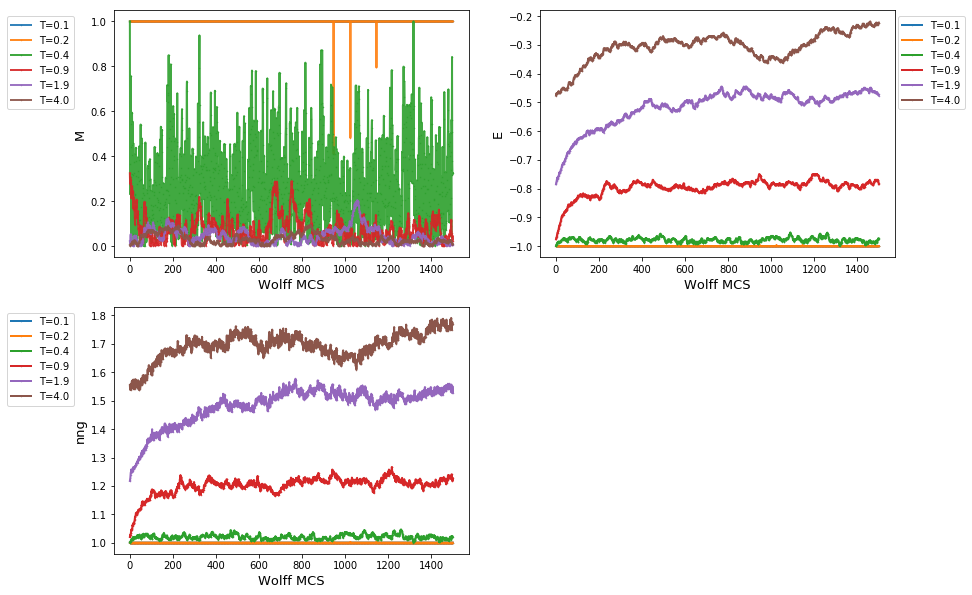

In [21]:
%matplotlib inline
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1); ax2 = fig.add_subplot(2,2,2); ax3 = fig.add_subplot(2,2,3)
save = False

if not save:
    EqData = pickle.load(open('1DeqData.p', 'rb'))
    t_sim = EqData['t_sim']; N = EqData['N']; mag_data = EqData['mag_data']; en_data = EqData['en_data'] 
    nng_data = EqData['nng_data']

t = np.arange(t_sim)

for i, item in enumerate(temperatures):
    ax1.plot(t,mag_data[i]/N, label = ('T={}'.format(np.around(item,1))), marker='.', linewidth=2, markersize=1, alpha=0.9)
    ax2.plot(t,en_data[i]/N, label = ('T={}'.format(np.around(item,1))), marker='.', linewidth=2, markersize=1)
    ax3.plot(t,nng_data[i]/N, label = ('T={}'.format(np.around(item,1))), marker='.', linewidth=2, markersize=1)
    
ax1.set_xlabel('Wolff MCS',fontsize=13); ax1.set_ylabel('M', fontsize=13)
ax2.set_xlabel('Wolff MCS',fontsize=13); ax2.set_ylabel('E', fontsize=13)
ax3.set_xlabel('Wolff MCS',fontsize=13); ax3.set_ylabel('nng', fontsize=13)
ax1.legend(loc=(-0.3,0.6)); ax2.legend(loc=(1.01,0.6)); ax3.legend(loc=(-0.3,0.6))


if save:
    plt.savefig('1Dequitime')
    EqData = {'t_sim': t_sim, 'N': N, 'mag_data': mag_data, 'en_data': en_data, 'nng_data': nng_data}
    pickle.dump(EqData, open('1DeqData.p', 'wb'))

### Correlation function

In [22]:
def corr_func_calc(x):
    ''' Calculated the correlation function of a data set (Magnetization/energy/specific heat/susceptibility)

        Parameters: 
            x: dtype numpy array or list
                One dimensional list or array containing the data
        
        Returns: dtype numpy array
            The correlation function'''
    
    t_max = len(x)
    c = np.zeros(t_max)
    for i in range(t_max):
        denom = t_max-i
        c[i] = (np.sum(x[:t_max-i]*x[i:t_max])/denom)-(np.sum(x[:t_max-i])*np.sum(x[i:t_max])/(denom**2))
    c = c/c[0]
    return(c)

In [23]:
def corr_time(corr, acc):
    ''' Automatically fits the correlation function to an exponention function and finds the decay length
        
        Parameters:
            corr: dtype numpy array
                The correlation function of a data set
            
        Returns: dtype float
            The decay length of the exponential fit'''
    
    l =0; k = np.argmax(corr<0)-1
    corr_decay = np.log(corr[l:k])
    t = np.arange(t_prod)
    #print(len(t[l:k]),len(corr_decay))
    slope, cep, r_val, _, err = sc.linregress(t[l:k], corr_decay)

    while r_val**2<acc:
        k -= 1
        slope, cep, r_val, _, err = sc.linregress(t[l:k], corr_decay[:k])
    
    #return (slope, cep, r_val, err, t[l:k], corr_decay[:k])
    #plt.plot(t[l:k],corr_decay[:k])
    #plt.plot(t[l:k],cep+slope*t[l:k])
    #plt.show()
    tau = -1/slope
    return(tau)

In [24]:
def corr_and_error(x):
    corr = corr_func_calc(x)
    if (corr[0]==np.nan) or (np.argmax(corr<0)<3):
        tau = 0
        sigma = np.std(x)
    else: 
        tau = corr_time(corr, 0.98)
        sigma = np.sqrt(2*(tau/len(x))*np.std(x))                    
    return(corr, tau, sigma)
       

Set temperatures:

In [25]:
temperatures = np.geomspace(0.1, 8, 34)
print(temperatures)

new = False
if new:
    possibleScales = []
    LcorrEdata = []; LtauEdata = []
    LcorrMdata = []; LtauMdata = []
    Lcorr_nng_data = []; Ltau_nng_data = []
    
    CorrData = {'possibleScales': possibleScales, 'temperatures': temperatures, 'LcorrEdata': LcorrEdata, 
                'LtauEdata': LtauEdata, 'LcorrMdata': LcorrMdata, 'LtauMdata': LtauMdata, 'Lcorr_nng_data': Lcorr_nng_data, 
                'Ltau_nng_data': Ltau_nng_data}
    pickle.dump(CorrData, open('1DcorrData.p', 'wb'))


[0.1        0.11420087 0.13041838 0.14893891 0.17008953 0.19424371
 0.221828   0.25332949 0.28930447 0.33038821 0.37730619 0.43088694
 0.49207661 0.56195575 0.64175832 0.73289356 0.83697078 0.95582787
 1.0915637  1.24657519 1.42359964 1.62576311 1.85663553 2.12029384
 2.42139391 2.76525279 3.1579426  3.60639777 4.11853745 4.70340539
 5.37132964 6.13410492 7.00520088 8.        ]


In [26]:
run = False

if run:
    #run = False
    # Set system parameters (note that these are global!):
    N = 64
    t_eq = 1000
    t_prod = 500
    t_sim = t_eq + t_prod
    
    corrEdata = []; tauEdata = np.zeros(len(temperatures)) 
    corrMdata = []; tauMdata = np.zeros(len(temperatures)) 
    corr_nng_data = []; tau_nng_data = np.zeros(len(temperatures)) 
    
    # Initial lattice configuration  
    lattice = -1*np.ones(N)  
    #lattice = np.random.choice([1,-1],size=(N))
    
    for j,T in enumerate(temperatures):
        A_wolff = np.exp(-2/T) # Needed for acceptance value for Wolff
        
        print('Performing simulation with T = ', T, 'and N = ', N)
        C, E, M, nng, _, _ = simulate_eff(lattice)
        clear_output(wait=True)
        
        lattice = np.copy(C[-1])
                        
        corrE, tauE, sigmaE = corr_and_error(E[t_eq:])
        corrM, tauM, sigmaM = corr_and_error(abs(M[t_eq:]))
        corr_nng, tau_nng, sigma_nng = corr_and_error(nng[t_eq:])
        
        if tau_nng > 16:
                print('fail')
                print(T)
                print(tauE)
                #run = True
                break
                                                               
        corrEdata.append(corrE); tauEdata[j] = tauE
        corrMdata.append(corrM); tauMdata[j] = tauM
        corr_nng_data.append(corr_nng); tau_nng_data[j] = tau_nng
            

tau_nng_data

idx = 0
#LcorrEdata[idx] = corrEdata; LtauEdata[idx] = tauEdata
#LcorrMdata[idx] = corrMdata; LtauMdata[idx] = tauMdata
Lcorr_nng_data[idx] = corr_nng_data; Ltau_nng_data[idx] = tau_nng_data

CorrData = {'possibleScales': possibleScales, 'temperatures': temperatures, 'LcorrEdata': LcorrEdata, 'LtauEdata': LtauEdata, 
                'LcorrMdata': LcorrMdata, 'LtauMdata': LtauMdata, 'Lcorr_nng_data': Lcorr_nng_data, 
                'Ltau_nng_data': Ltau_nng_data}
pickle.dump(CorrData, open('1DcorrData.p', 'wb'))

In [28]:
CorrData = pickle.load(open('1DcorrData.p', 'rb'))
possibleScales = CorrData['possibleScales']; temperatures = CorrData['temperatures']
LcorrEdata = CorrData['LcorrEdata']; LtauEdata = CorrData['LtauEdata']
LcorrMdata = CorrData['LcorrMdata']; LtauMdata = CorrData['LtauMdata']
Lcorr_nng_data = CorrData['Lcorr_nng_data']; Ltau_nng_data = CorrData['Ltau_nng_data']

save = False
if save:
    possibleScales.append(N)
    LcorrEdata.append(corrEdata); LtauEdata.append(tauEdata)
    LcorrMdata.append(corrMdata); LtauMdata.append(tauMdata)
    Lcorr_nng_data.append(corr_nng_data); Ltau_nng_data.append(tau_nng_data)
    
    CorrData = {'possibleScales': possibleScales, 'temperatures': temperatures, 'LcorrEdata': LcorrEdata, 'LtauEdata': LtauEdata, 
                'LcorrMdata': LcorrMdata, 'LtauMdata': LtauMdata, 'Lcorr_nng_data': Lcorr_nng_data, 
                'Ltau_nng_data': Ltau_nng_data}
    pickle.dump(CorrData, open('1DcorrData.p', 'wb'))

In [29]:
save = False

if not save:
    CorrData = pickle.load(open('1DcorrData.p', 'rb'))
    possibleScales = CorrData['possibleScales']; temperatures = CorrData['temperatures']
    LcorrEdata = CorrData['LcorrEdata']; LtauEdata = CorrData['LtauEdata']
    LcorrMdata = CorrData['LcorrMdata']; LtauMdata = CorrData['LtauMdata']
    Lcorr_nng_data = CorrData['Lcorr_nng_data']; Ltau_nng_data = CorrData['Ltau_nng_data']

tauData = [['','MAXtauE', 'MAXtauM', 'Maxtau_nng']]

for i,L in enumerate(possibleScales):
    row = []
    tauE = round(max(LtauEdata[i]),3); tauM = round(max(LtauMdata[i]),3); tau_nng = round(max(Ltau_nng_data[i]),3)
    j = np.argmax(LtauEdata[i]); k = np.argmax(LtauMdata[i]); l = np.argmax(Ltau_nng_data[i])
    T1 = temperatures[j]; T2 = temperatures[k]; T3 = temperatures[l]
    row.append('L = %d'%(L)); row.append('%.1f (T=%.2f)'%(tauE,T1)); row.append('%.1f (T=%.2f)'%(tauM,T2))
    row.append('%.1f (T=%.2f)'%(tau_nng,T3))
    tauData.append(row)
    
display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in tauData)
       )
))

if save:
    CorrData = {'possibleScales': possibleScales, 'temperatures': temperatures, 'LcorrEdata': LcorrEdata, 'LtauEdata': LtauEdata, 
                'LcorrMdata': LcorrMdata, 'LtauMdata': LtauMdata, 'Lcorr_nng_data': Lcorr_nng_data, 
                'Ltau_nng_data': Ltau_nng_data}
    pickle.dump(CorrData, open('1DcorrData.p', 'wb'))

,MAXtauE,MAXtauM,Maxtau_nng
L = 64,20.9 (T=3.61),9.3 (T=8.00),15.9 (T=4.12)
L = 256,45.6 (T=1.63),39.6 (T=8.00),43.6 (T=3.16)
L = 784,95.0 (T=7.01),129.8 (T=7.01),89.9 (T=7.01)
L = 1024,178.9 (T=5.37),136.6 (T=4.12),111.1 (T=2.42)


L = 1024


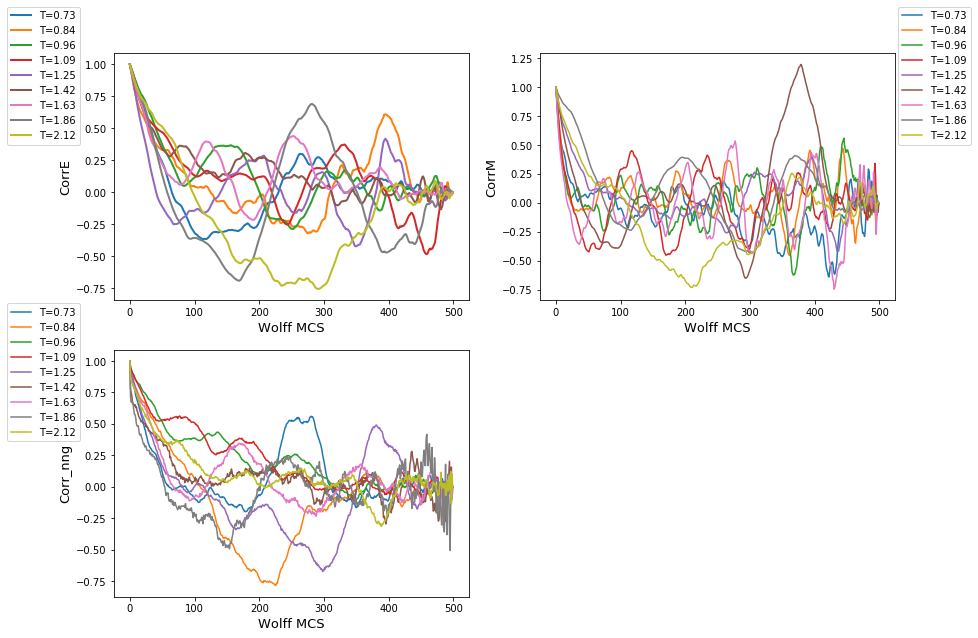

In [30]:
%matplotlib inline
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1); ax2 = fig.add_subplot(2,2,2); ax3 = fig.add_subplot(2,2,3)
t = np.arange(len(LcorrEdata[0][0]))
i = 3 # index of scales
l = 15; k = 24

for j, item in enumerate(temperatures[l:k:]):
    ax1.plot(t,LcorrEdata[i][j+l], linewidth=2, label=('T={}'.format(np.around(item,2))))
    ax2.plot(t, LcorrMdata[i][j+l], label=('T={}'.format(np.around(item,2))))
    ax3.plot(t, Lcorr_nng_data[i][j+l], label=('T={}'.format(np.around(item,2))))

    
ax1.set_xlabel('Wolff MCS',fontsize=13); ax1.set_ylabel('CorrE', fontsize=13)
ax2.set_xlabel('Wolff MCS',fontsize=13); ax2.set_ylabel('CorrM', fontsize=13)
ax3.set_xlabel('Wolff MCS',fontsize=13); ax3.set_ylabel('Corr_nng', fontsize=13)
ax1.legend(loc=(-0.3,0.63)); ax2.legend(loc=(1.01,0.63)); ax3.legend(loc=(-0.3,0.63))

print('L = %d'%(possibleScales[i]))
#print('Correlation time (decay length) of the energy(nng):', LtauE[i])
#print('Correlation time (decay length) of the magnetization:', LtauM[i])


### Average energy

In [31]:
scales = [64, 256, 784, 1024]
print(scales)
print(len(temperatures))
print(temperatures)

[64, 256, 784, 1024]
34
[0.1        0.11420087 0.13041838 0.14893891 0.17008953 0.19424371
 0.221828   0.25332949 0.28930447 0.33038821 0.37730619 0.43088694
 0.49207661 0.56195575 0.64175832 0.73289356 0.83697078 0.95582787
 1.0915637  1.24657519 1.42359964 1.62576311 1.85663553 2.12029384
 2.42139391 2.76525279 3.1579426  3.60639777 4.11853745 4.70340539
 5.37132964 6.13410492 7.00520088 8.        ]


In [33]:
# Set system parameters (note that these are global!):
#scales = [64, 256, 784, 1024] # Lattice number
#temperatures = np.linspace(0.01, 8, 60) # Temperature (critical at around 0)
#temperatures = np.sort(np.random.normal(0.01,0.6,50))# Temperature (critical at around 0)

run = False
if run:
    Len_data = []; Len_err = []
    Lmag_data = []; Lmag_err = []
    Lnng_data = []; Lnng_err = []
    Lcol_data = []; Lcol_norm_data = []
    L_CvEdata = []; L_Cv_nng_data = []
    Lsusc_data = []

    for N in scales:
        t_eq = 1000
        t_prod = 25000
        t_sim = t_eq + t_prod
    
        en_data = np.zeros(len(temperatures)); en_err = np.zeros(len(temperatures))#; tausE = []
        mag_data = np.zeros(len(temperatures)); mag_err = np.zeros(len(temperatures))
        nng_data = np.zeros(len(temperatures)); nng_err = np.zeros(len(temperatures))#; taus_nng = []
        col_data = np.zeros(len(temperatures)); col_norm_data = np.zeros(len(temperatures))
    
        CvEdata = np.zeros(len(temperatures)); Cv_nng_data = np.zeros(len(temperatures))
        susc_data = np.zeros(len(temperatures))

        # Initial lattice configuration
        lattice = -1*np.ones(N)  
        #lattice = np.random.choice([1,-1],size=N)

        for j,T in enumerate(temperatures):
            #exp = np.array([np.exp(-8/T),np.exp(-4/T),1,np.exp(4/T),np.exp(8/T)]) # Store possible values of the acceptance probability 
            # (only need first two values for metropolis)
            A_wolff = np.exp(-2/T) # Needed for acceptance value for Wolff
    
            print('Performing simulation with T = ', T, 'and N = ', N)
            C, E, M, nng, col, col_norm = simulate_eff(lattice)
            clear_output(wait=True)
    
            lattice = np.copy(C[-1])
        
            en_data[j] = np.mean(E[t_eq:]); en_err[j] = np.std(E[t_eq:])#; tausE[j] = tauE
            mag_data[j] = np.mean(abs(M[t_eq:])); mag_err[j] = np.std(abs(M[t_eq:]))
            nng_data[j] = np.mean(nng[t_eq:]); nng_err[j] = np.std(nng[t_eq:])
            col_data[j] = col; col_norm_data[j] = col_norm
 
            CvEdata[j] = specific_heat(E[t_eq:]); Cv_nng_data[j] = specific_heat(nng[t_eq:])
            susc_data[j] = susceptiblity(abs(M[t_eq:]))
        
        Len_data.append(en_data); Len_err.append(en_err)#; LtausE.append(tausE)
        Lmag_data.append(mag_data); Lmag_err.append(mag_err)
        Lnng_data.append(nng_data); Lnng_err.append(nng_err)#; Ltaus_nng.append(taus_nng)
        Lcol_data.append(col_data); Lcol_norm_data.append(col_norm_data)
        L_CvEdata.append(CvEdata); L_Cv_nng_data.append(Cv_nng_data)
        Lsusc_data.append(susc_data)

else:
    Ldata = pickle.load(open('1Dfinite_size_scaling_data.p', 'rb'))
    Len_data = Ldata['Len_data']; Len_err = Ldata['Len_err']; L_CvEdata = Ldata['L_CvEdata']
    Lnng_data = Ldata['Lnng_data']; Lnng_err = Ldata['Lnng_err']; L_Cv_nng_data = Ldata['L_Cv_nng_data']
    temperatures = Ldata['temperatures']; scales = Ldata['scales']

    Ldata_mag = pickle.load(open('1Dfinite_size_scaling_data_mag.p', 'rb'))
    Lmag_data= Ldata_mag['Lmag_data']; Lmag_err = Ldata_mag['Lmag_err']; Lsusc_data = Ldata_mag['Lsusc_data']

    Ldata_col = pickle.load(open('1Dfinite_size_scaling_data_col.p', 'rb'))
    Lcol_data= Ldata_col['Lcol_data']; Lcol_norm_data = Ldata_col['Lcol_norm_data']

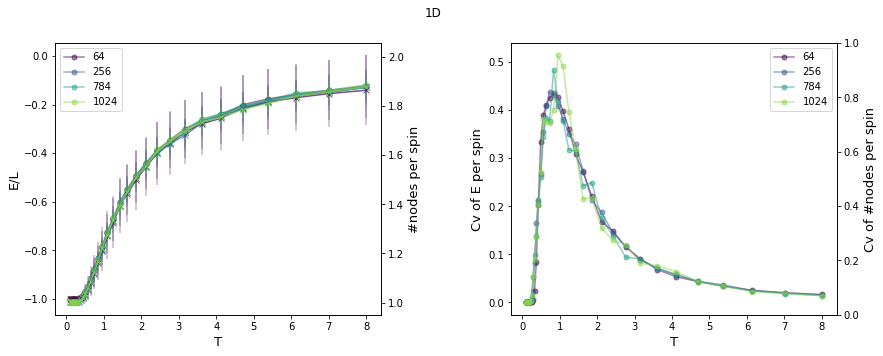

In [34]:
# Energy ~ Number of Nodes
%matplotlib inline
save = False

fig4 = plt.figure(figsize=(14,5)); fig4.suptitle('1D')
fig4.subplots_adjust(wspace=0.4)
# energy:
ax41 = fig4.add_subplot(1,2,1); ax42 = ax41.twinx()
ax41.set_xlabel('T',fontsize=13)
ax41.set_ylabel('E/L', fontsize=13)#, color='y')
ax42.set_ylabel('#nodes per spin', fontsize=13)#, color='r')
# specific heat:
ax43 = fig4.add_subplot(1,2,2); ax44 =ax43.twinx()
ax43.set_xlabel('T',fontsize=13)
ax43.set_ylabel('Cv of E per spin', fontsize=13)
ax44.set_ylabel('Cv of #nodes per spin', fontsize=13)

for i,L in enumerate(scales):
    # energy:
    ax41.plot(temperatures, Len_data[i]/L, marker='o', markersize=5, alpha=0.5, label='%d'%(L), color=cm.viridis(i*70))
    ax41.errorbar(temperatures, Len_data[i]/L, yerr=Len_err[i]/L, alpha=0.3, linestyle='', color=cm.viridis(i*70))
    ax42.plot(temperatures, (Lnng_data[i])/L, marker='x',markersize=6, alpha=0.7, label='%d'%(L), color=cm.viridis(i*70))
    ax42.errorbar(temperatures, Lnng_data[i]/L, yerr=Lnng_err[i]/L, linestyle='', alpha=0.3, color=cm.viridis(i*70))
    # specific heat:
    ax43.plot(temperatures, L_CvEdata[i]/L, marker='o', markersize=5, alpha=0.5, label='%d'%(L), color=cm.viridis(i*70))
    #ax44.plot(temperatures, L_Cv_nng_data[i]/L, marker='x', markersize=6, alpha=0.7, label='%d'%(L), color=cm.viridis(i*70))

ax41.legend()
ax43.legend()

if save:
    # Save data as dictionary:
    Ldata = {'Len_data': Len_data, 'Len_err': Len_err, 'Lnng_data': Lnng_data, 'Lnng_err': Lnng_err, 'L_CvEdata': L_CvEdata, 
             'L_Cv_nng_data': L_Cv_nng_data, 'temperatures': temperatures, 'scales': scales, 't_prod': t_prod}
    pickle.dump(Ldata, open('1Dfinite_size_scaling_data.p', 'wb'))

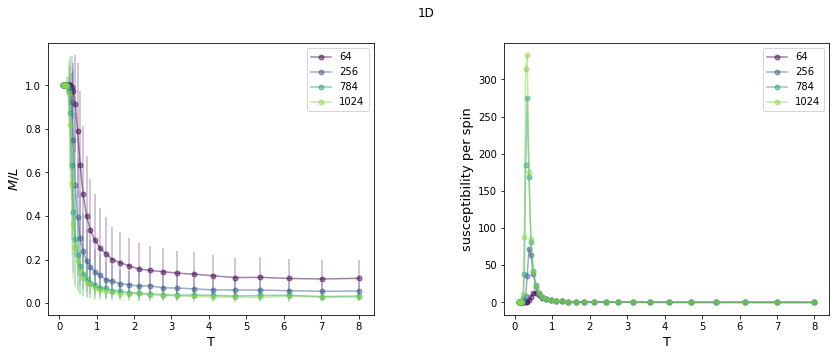

In [35]:
# magnetization ~ susceptibility
%matplotlib inline
save = False

fig4 = plt.figure(figsize=(14,5)); fig4.suptitle('1D')
fig4.subplots_adjust(wspace=0.4)
# magnetization:
ax41 = fig4.add_subplot(1,2,1)
ax41.set_xlabel('T',fontsize=13)
ax41.set_ylabel('$M/L$', fontsize=13)#, color='y')

# susceptibility:
ax43 = fig4.add_subplot(1,2,2)
ax43.set_xlabel('T',fontsize=13)
ax43.set_ylabel('susceptibility per spin', fontsize=13)

for i,L in enumerate(scales):
    # magnetization:
    ax41.plot(temperatures, Lmag_data[i]/L, marker='o', markersize=5, alpha=0.5, label='%d'%(L), color=cm.viridis(i*70))
    ax41.errorbar(temperatures, Lmag_data[i]/L, yerr=Lmag_err[i]/L, alpha=0.3, linestyle='', color=cm.viridis(i*70))
    #ax42.errorbar(temperatures, Lnng_data[i], yerr=Lnng_err[i], linestyle='', alpha=0.3, color=cm.viridis(i*70))
    # susceptibility:
    ax43.plot(temperatures, Lsusc_data[i]/L, marker='o', markersize=5, alpha=0.5, label='%d'%(L), color=cm.viridis(i*70))
ax41.legend()
ax43.legend()

if save:
    # Save data as dictionary:
    Ldata_mag = {'Lmag_data': Lmag_data, 'Lmag_err': Lmag_err, 'Lsusc_data': Lsusc_data, 'temperatures': temperatures, 
                 'scales': scales, 't_prod': t_prod}
    pickle.dump(Ldata_mag, open('1Dfinite_size_scaling_data_mag.p', 'wb'))

C:\Users\Joseph\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


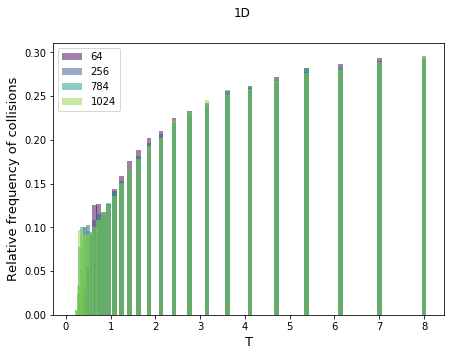

In [36]:
# relative frequency of collisions in averaging over spin domains procedure
%matplotlib inline
save = False

fig1 = plt.figure(figsize=(7,5)); fig1.suptitle('1D')
ax11 = fig1.add_subplot(1,1,1)

ax11.set_xlabel('T',fontsize=13)
ax11.set_ylabel('Relative frequency of collisions', fontsize=13, color='black')

for i,L in enumerate(scales):
    ax11.bar(temperatures, Lcol_data[i]/Lcol_norm_data[i], align='center', width=0.1, alpha=0.5, label='%d'%(L), 
             color=cm.viridis(i*70))
    
ax11.legend(loc='upper left')

if save:
    # Save data as dictionary:
    Ldata_col = {'Lcol_data': Lcol_data, 'Lcol_norm_data': Lcol_norm_data, 'temperatures': temperatures, 
                 'scales': scales, 't_prod': t_prod}
    pickle.dump(Ldata_col, open('1Dfinite_size_scaling_data_col.p', 'wb'))

In [37]:
for i,L in enumerate(scales):
    print(L)
    print(np.sum(Lcol_data[i])/np.sum(Lcol_norm_data[i]))

64
0.2394287444643398
256
0.2345390627493117
784
0.2346823747122142
1024
0.23388071961458998


# Free energy

In [38]:
def exc_free_energy_calc():
    f = np.zeros(len(temperatures))
    for i,T in enumerate(temperatures):
        f[i] = -T*np.log(2*np.cosh(1/T))
    return f

In [39]:
def create_energy_hist(x, mode):
    lowB = np.min(x)
    upperB = np.max(x)
    if mode == 'nng':
        n = round(abs(upperB-lowB)*0.19)+2   
    else:
        n = round(abs(upperB-lowB)*50)+2
    bin_edges = np.linspace(lowB,upperB,n)
    print(n)
    #bin_edges = np.histogram_bin_edges(en, bins='doane')
    h, b = np.histogram(x, bins=bin_edges)#, density=True)
    #h, b = stats.histogram(x, bins='blocks')
    idx = np.where(h>0)
    h = h[idx]
    b = b[idx]
    return h, b
    

In [40]:
def free_energy_calc(nE, en, g, temp):
    f = -temp*np.log(g/nE) + en
    return f

In [41]:
def g_transfer(nE1, en1, g1, nE2, en2, temp):
    g2 = round(g1*(nE2/nE1)*np.exp(-(1/temp)*(en1-en2)))
    return g2

In [42]:
def find_intersection(x_targ, y_targ, x2, y2):
    m = len(x_targ)
    n = len(x2)
    min_dist = 10000
    coords = np.zeros((2,2))
    for i in range(m):
        for j in range(n):
            d = (x2[j]-x_targ[i])**2 + (y2[j]-y_targ[i])**2
            if d < min_dist:
                min_dist = d
                coords[0][0] = x_targ[i]
                coords[0][1] = y_targ[i]
                coords[1][0] = x2[j]
                coords[1][1] = y2[j]
    return(coords)

In [43]:
def free_energyVStemp(hists, bins, g0):
    f = np.zeros(len(temperatures))
    idx = np.argmax(hists[0])
    nE = hists[0][idx]
    en = bins[0][idx]
    g = g0
    
    for i,temperature in enumerate(temperatures):
        #print('g',g)
        f[i] = free_energy_calc(nE, en, g, temperature)   
        
        if i == (len(temperatures)-1):
            break
        #print(i)
        hist1 = hists[i]
        bins1 = bins[i]
        hist2 = hists[i+1]
        bins2 = bins[i+1]
        l = np.argmax(hist1)
        k = np.argmax(hist2)+1
        #print('l:', l, 'k:', k)
        if bins2[k-1] < bins1[l]:
            raise ValueError('Data of consecutive histograms %d and %d are not consecutive'%(i,i+1))
          
        # get intersection
        coords = find_intersection(bins1[l:], hist1[l:], bins2[:k], hist2[:k])
        
        en1 = coords[0][0]
        nE1 = coords[0][1]
               
        g = g_transfer(nE, en, g, nE1, en1, temperature)
        #print(coords)
        en = coords[1][0]
        nE = coords[1][1]  
    return f
            

In [44]:
def check_visual(i, hists, bins):

    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot(1,1,1)
    
    b1 = bins[i]
    h1 = hists[i]
    print(b1)
    l = np.argmax(h1)
    temperature1 = temperatures[i]
    
    b2 = bins[i+1]
    h2 = hists[i+1]
    k = np.argmax(h2)+1
    temperature2 = temperatures[i+1]
    
    ax.plot(b1/N, h1,label='T=%.2f'%(temperature1), markersize=3, linestyle='-', marker='o', linewidth=1, color='#1f77b4')
    ax.plot(b1[l:]/N, h1[l:], markersize=6, color='#1f77b4', marker='o', linewidth=2)
    
    ax.plot(b2/N, h2,label='T=%.2f'%(temperature2), markersize=3, linestyle='-', marker='o', linewidth=1, color='orange')
    ax.plot(b2[:k]/N, h2[:k], markersize=6, color='orange', marker='o', linewidth=2)
    
    ax.legend()
    #ax5.set_yscale('log')

### Free Energy Simulation

In [48]:
lowRange = np.arange(0.1, 1.1, 0.095)
highRange = np.geomspace(1.1, 6, 14)
temperatures = np.sort(np.concatenate((lowRange,highRange)))
print(len(temperatures))
print(temperatures)

f_exact = exc_free_energy_calc()

new = False
if new:
    scales = []
    Len_data = []#; Len_err = []
    Len_hist_data = []; Len_bin_edges_data = []
    Len_fr = []; LenS = []
    
    # Save data as dictionary:
    Lf_data = {'f_exact': f_exact, 'Len_fr': Len_fr, 'LenS': LenS, 'Len_data': Len_data, 
                  'Len_err': Len_err, 'Len_hist_data': Len_hist_data, 
                  'Len_bin_edges_data': Len_bin_edges_data, 'temperatures': temperatures, 'scales': scales, 
                  't_prod': t_prod}
    pickle.dump(Lf_data, open('1Dfree_energy_finite_size_scaling.p', 'wb'))

25
[0.1        0.195      0.29       0.385      0.48       0.575
 0.67       0.765      0.86       0.955      1.05       1.1
 1.25333284 1.42803929 1.62709868 1.85390565 2.11232804 2.40677283
 2.74226131 3.12451469 3.56005172 4.05629977 4.62172157 5.2659595
 6.        ]


In [46]:
# Set system parameters (note that these are global!):
#low_range = np.linspace(0.1, 3, 20); high_range = np.linspace(3.5, 6, 5)
#temperatures = np.concatenate((low_range, high_range))
#temperatures = np.linspace(0.1, 5, 25) # Temperature (critical at around 2.27)
#temperatures = np.arange(0.1, 6, 0.19)

run = False

if run:
    N = 1024
    t_eq = 1000
    t_prod = 40000
    t_sim = t_eq + t_prod
    
    en_data = np.zeros(len(temperatures)); en_err = np.zeros(len(temperatures))
    en_hist_data = []; en_bin_edges_data = []

    # Initial lattice configuration
    lattice = -1*np.ones(N)  
    # lattice = np.random.choice([1,-1],size=(N,N))
  
    for j,T in enumerate(temperatures):
        #exp = np.array([np.exp(-8/T),np.exp(-4/T),1,np.exp(4/T),np.exp(8/T)]) # Store possible values of the acceptance 
        #probability (only need first two values for metropolis)
        A_wolff = np.exp(-2/T) # Needed for acceptance value for Wolff
    
        print('Performing simulation with T = ', T, 'and N = ', N)
        C, E, M, nng, _, _ = simulate_eff(lattice)
        clear_output(wait=True)
    
        lattice = np.copy(C[-1])
        
        en_hist, en_bin_edges = create_energy_hist(E[t_eq:], 'en')
        
        en_data[j] = np.mean(E[t_eq:]); en_err[j] = np.std(E[t_eq:])
        
        en_hist_data.append(en_hist/t_prod); en_bin_edges_data.append(en_bin_edges)
        

### Visually check histograms

NameError: name 'en_bin_edges_data' is not defined

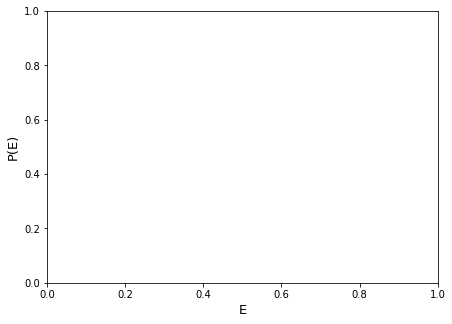

In [43]:
%matplotlib inline
fig5 = plt.figure(figsize=(7,5))
ax5 = fig5.add_subplot(1,1,1)
ax5.set_xlabel('E', fontsize=13)
ax5.set_ylabel('P(E)', fontsize=13)

l = 1
k = 15
for i,temperature in enumerate(temperatures[l:k+1]):
    ax5.plot(en_bin_edges_data[l+i]/N, en_hist_data[l+i],label='T=%.2f'%(temperature), markersize=4, linestyle='-', 
             marker='o')
    
ax5.legend()
#ax5.set_yscale('log')

In [72]:
%matplotlib inline
wg.interact(check_visual, hists=wg.fixed(en_hist_data), bins=wg.fixed(en_bin_edges_data), i=(0,len(temperatures)-2))

interactive(children=(IntSlider(value=11, description='i', max=23), Output()), _dom_classes=('widget-interact'…

<function __main__.check_visual(i, hists, bins)>

### Plot free energy

In [47]:
#f_exact = exc_free_energy_calc()
en_fr = free_energyVStemp(en_hist_data, en_bin_edges_data, 1)
print(en_fr)


NameError: name 'en_hist_data' is not defined

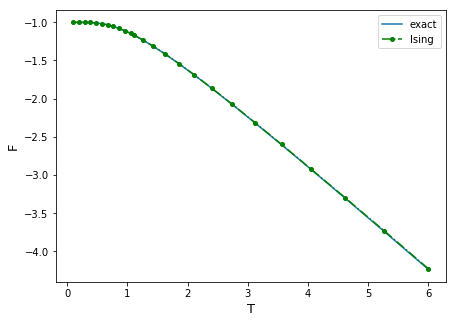

In [74]:
%matplotlib inline
fig7 = plt.figure(figsize=(7,5))
ax7 = fig7.add_subplot(1,1,1)#; ax8 = ax7.twinx()
ax7.set_xlabel('T', fontsize=13)
ax7.set_ylabel('F', fontsize=13)
#ax8.set_ylabel('Network F', fontsize=13, color='g')

ax7.plot(temperatures, f_exact, label='exact')
ax7.plot(temperatures, en_fr/N, label='Ising', linestyle='-.', color='y', marker='o', markersize=4)

ax7.legend()

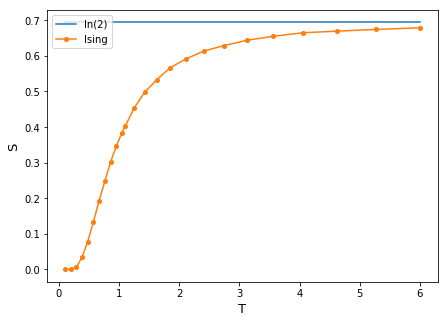

In [75]:
%matplotlib inline
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1)#; ax1 = ax.twinx()
ax.set_xlabel('T', fontsize=13)
ax.set_ylabel('S', fontsize=13)
#ax1.set_ylabel('nng S', fontsize=13, color='g')

enS = (en_data-en_fr)/(temperatures)
ax.plot(temperatures, np.tile(np.log(2), len(temperatures)), label='ln(2)')
ax.plot(temperatures, enS/N, label='Ising', marker='o', markersize=4)


ax.legend(loc='upper left')

In [49]:
Lf_data = pickle.load(open('1Dfree_energy_finite_size_scaling.p', 'rb'))
f_exact = Lf_data['f_exact']; Len_fr = Lf_data['Len_fr']; LenS = Lf_data['LenS'] 
Len_data = Lf_data['Len_data'] ; Len_err = Lf_data['Len_err'] 
Len_hist_data = Lf_data['Len_hist_data']; Len_bin_edges_data = Lf_data['Len_bin_edges_data']
temperatures = Lf_data['temperatures']; scales = Lf_data['scales']

save = False
if save:
    scales.append(N)
    Len_fr.append(en_fr); LenS.append(enS)
    Len_data.append(en_data); Len_err.append(en_err)
    Len_hist_data.append(en_hist_data); Len_bin_edges_data.append(en_bin_edges_data)
    
    # Save energy data as dictionary:
    Lf_data = {'f_exact': f_exact, 'Len_fr': Len_fr, 'LenS': LenS, 'Len_data': Len_data, 'Len_err': Len_err, 
               'Len_hist_data': Len_hist_data, 'Len_bin_edges_data': Len_bin_edges_data, 'temperatures': temperatures, 
               'scales': scales, 't_prod': t_prod}
    pickle.dump(Lf_data, open('1Dfree_energy_finite_size_scaling.p', 'wb'))
    

In [50]:
print(scales)

[64, 256, 784, 1024]


### Plot free energy for various system size 

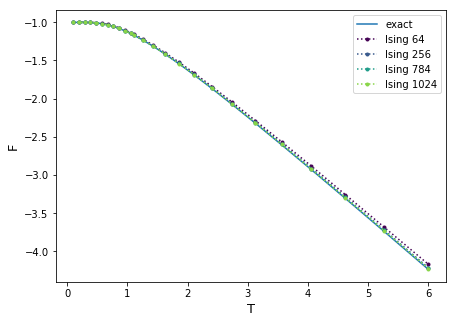

In [51]:
%matplotlib inline

fig8 = plt.figure(figsize=(7,5))
ax8 = fig8.add_subplot(1,1,1)#; ax9 = ax8.twinx()
ax8.set_xlabel('T', fontsize=13)
ax8.set_ylabel('F', fontsize=13)
#ax9.set_ylabel('nng F', fontsize=13)

ax8.plot(temperatures, f_exact, label='exact')

for i,L in enumerate(scales):
    ax8.plot(temperatures, Len_fr[i]/L, label='Ising %d'%(L), linestyle=':', color=cm.viridis(i*70), marker='o', 
             markersize=3)
    #ax9.plot(temperatures, Lnng_fr[i]/L, label='nng %d'%(L), linestyle='-', color=cm.viridis(i*70), marker='x', markersize=8)
    
ax8.legend()
#ax9.legend(loc='lower left')

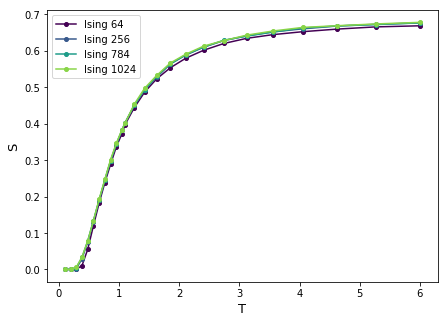

In [52]:
%matplotlib inline
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1)#; ax1 = ax.twinx()
ax.set_xlabel('T', fontsize=13)
ax.set_ylabel('S', fontsize=13)
#ax1.set_ylabel('nng S', fontsize=13)

for i,L in enumerate(scales):
    ax.plot(temperatures, LenS[i]/L, color=cm.viridis(i*70), marker='o', markersize=4, label='Ising %d'%(L))
    #ax1.plot(temperatures, nng_S, color=cm.viridis(i*70), marker='x', markersize=8)
    
ax.legend()